# Plane's Windows

#### This exercices aims to build an algorithm to detect windows which are abnormal.

1/ With this information and no more, formulate the problem, and tell him what is feasible and what is not.

2/ Develop an approach to answer his question in the best way possible.

3/ Present your findings to the expert, in a way he can understand and help you validate your results...

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.decomposition import PCA

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [115]:
data = pd.read_csv("./data/dataset.csv")

# Liste des noms des fenêtres
windows = sorted(list(set(data['day_cycle_window'])))

# nombre de fenêtres
n_window = len(windows)

# nombre de données
n_data = data.shape[0]

# Assimiler chaque fenêtre à sa moyenne

On va regarder s'il existe des "gros" outliers (données n'étant pas du même ordre de grandeur) dans le dataset. Si c'est le cas, on retirera ces valeurs. Pour ce faire, nous allons comparer la moyenne et la médiane de chaque fenêtre. Si l'écart relatif entre ces deux valeurs est élevé, cela signifie qu'un "gros" outlier se situe dans la fenêtre considérée.

Rappel : $e = \lvert \frac{med(x) - moy(x)}{min(med(x);moy(x))} \rvert$

In [116]:
df_med = data.groupby(['day_cycle_window']).median()
df_mean = data.groupby(['day_cycle_window']).mean()

# Calcul des écarts relatifs
distances = []
for i in range(df_mean.shape[0]):
    dist = 0
    for col in df_mean.columns:
        dist += abs((df_mean[col][i]-df_med[col][i])/np.max([abs(df_mean[col][i]), abs(df_med[col][i])]))
    distances.append(round(dist,2))

    
print("Ecart relatif maximal : {}".format(np.max(distances)))

Ecart relatif maximal : 10.5


Comme les écarts entre médiane et moyenne sont assez faibles, le choix de représenter chaque fenêtre par sa valeur moyenne semble cohérent.

### ACP

Comme nous avons un tableau de données avec 11 variables, il est difficile de représenter graphiquement les données. Pour cela, nous allons utiliser une Analyse en Composantes Principales pour nous ramener à un problème en 2D (et 3D plus tard).

In [128]:
# ACP en 2D
pca_mean = PCA(n_components=2)

principalComponents = pca_mean.fit_transform(df_mean)

# Tableau de coordonnées des données initiales dans le plan principal
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Variance expliquée par les deux composantes principales
print("Variance expliquée : {}%".format(round(np.sum(pca_mean.explained_variance_ratio_)*100,2)))

Variance expliquée : 75.63%


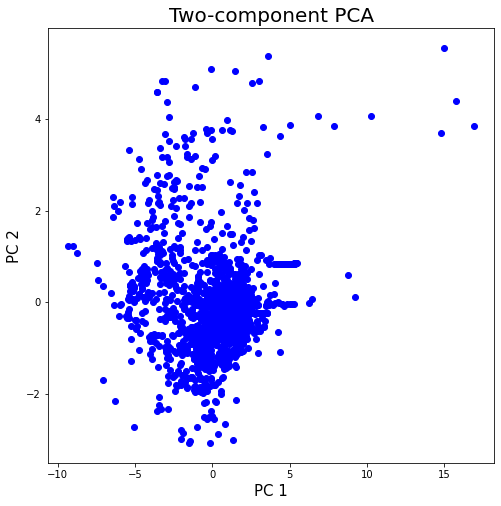

In [129]:
# Représentation dans le plan principal

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Two-component PCA', fontsize = 20)
plt.scatter(principalDf["principal component 1"], principalDf["principal component 2"], color='b')

### Méthodes d'outliers

Pour détecter les anomalies, nous allons utiliser quatre méthodes :
- Elliptic Envelope (with the Mahalanobis distance)
- Isolation Forest
- Local Outlier Factor (LOF)
- One-class SVM

In [130]:
def fit_predict(df, clf):
    clf.fit(df)
    ypred = clf.predict(df)
    return ypred

# Affichage dans le plan principal des anomalies
def plot2D(df, clf_name, contaminations, fig, ypred, i):
    ax = fig.add_subplot(int(len(contaminations)+1/2),2,i+1)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA \n Method : {} \n Contamination rate : {}'.format(clf_name,round(contaminations[i],3)))
    plt.scatter(df["principal component 1"], df["principal component 2"], color='b', label='Valid data')
    plt.plot(df["principal component 1"][ypred==-1],df["principal component 2"][ypred==-1],'r.', label='Anomalies')
    plt.legend(loc='upper right')

In [131]:
# Détecte les anomalies dans le dataset en fonction de la méthode spécifiée. 
# L'affichage dans le plan principal est optionel.  
def runAnomalies(df, clf_name, contaminations, display=True):
    
    predictions = []
    
    if display:
        fig = plt.figure(figsize=(20,10*int(len(contaminations)+1/2)))
    
    # One class SVM
    if clf_name == 'SVM':
        for i in range(len(contaminations)):
            # Création du classificateur
            clf = OneClassSVM(nu=contaminations[i], kernel="rbf", gamma=0.3)
            
            # Prédiction
            ypred = fit_predict(df, clf)
            predictions.append(ypred)
            
            # Affichage
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
    
    # Elliptic Envelope
    elif clf_name == 'Elliptic':
        for i in range(len(contaminations)):
            # Création du classificateur
            clf = EllipticEnvelope(contamination=contaminations[i])
            
            # Prédiction
            ypred = fit_predict(df, clf)
            predictions.append(ypred)
            
            # Affichage
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
    
    # Isolation Forest
    elif clf_name == 'Forest':
        for i in range(len(contaminations)):
            # Création du classificateur
            clf = IsolationForest(behaviour='new', n_estimators=100, contamination=contaminations[i])
            
            # Prédiction
            ypred = fit_predict(df, clf)
            predictions.append(ypred)
            
            # Affichage
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
    
    # Local Outlier Factor
    elif clf_name == 'LOF':
        for i in range(len(contaminations)):
            # Création du classificateur
            clf = LocalOutlierFactor(n_neighbors=5, contamination=contaminations[i], novelty=True)
            
            # Prédiction
            ypred = fit_predict(df, clf)
            predictions.append(ypred)
            
            # Affichage
            if display:
                plot2D(df, clf_name, contaminations, fig, ypred, i)
    
    # Message d'erreur
    else:
        print("Error : The method is not known. Please select either 'SVM', 'Elliptic', 'Forest' or 'LOF'.")
    
    # Renvoie la dernière prédiction
    return predictions

Dans l'exemple suivant, nous lançons quatre tests pour détecter les anomalies dans le dataset avec la méthode de Local Outlier Factor avec quatre valeurs de contamination rate

[array([-1, -1,  1, ...,  1,  1,  1]),
 array([-1, -1,  1, ...,  1,  1,  1]),
 array([-1, -1,  1, ...,  1,  1,  1]),
 array([-1, -1,  1, ...,  1,  1,  1])]

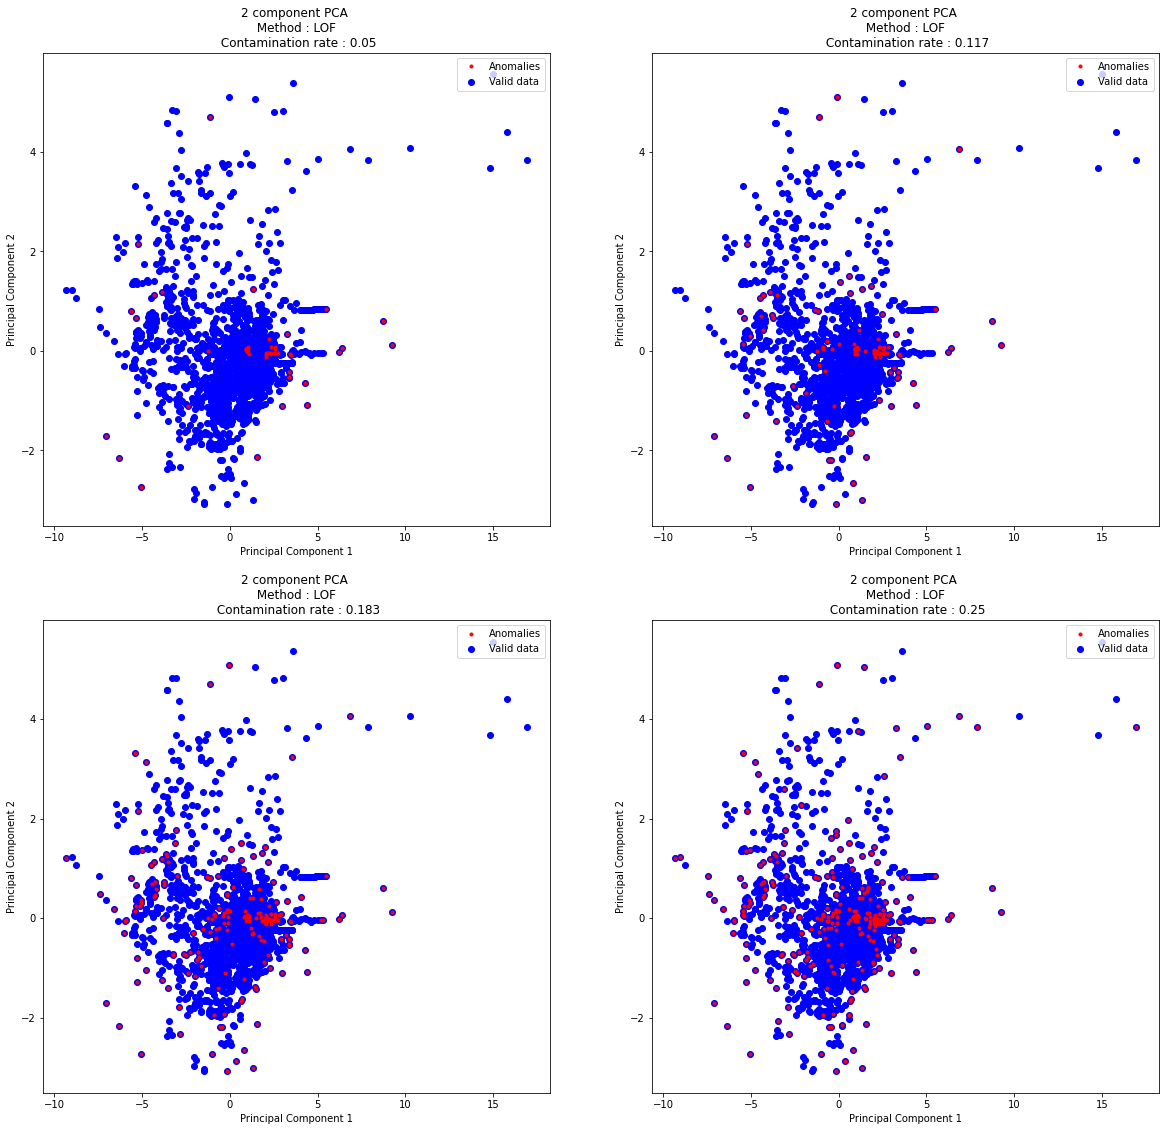

In [132]:
# Taux de contamination
contaminations = np.linspace(0.05,0.25,4)
clf_name = "LOF"

runAnomalies(principalDf, clf_name, contaminations)

On regarde si une donnée est détectée par plusieurs méthodes grâce au score d'une donnée. On définit le score comme étant le nombre de méthodes qui ont détécté une fenêtre comme étant une anomalie. 
Pour éviter un temps de calcul trop long, nous menons cette étude pour seulement une valeur de contamination rate égale à 0,1. Dans un cadre connu, cette valeur doit être adaptée en fonction du dataset. Ici, ne possédant aucune information quant à la signification des données, nous avons choisi cette valeur arbitrairement.

In [133]:
contamination_rate = 0.1

On lance les tests avec les quatre méthodes.

In [134]:
methods = ["Elliptic", "LOF", "SVM", "Forest"]
predictions = []
for clf_name in methods:
    print("Method : {}".format(clf_name))
    predictions.append(runAnomalies(principalDf, clf_name, [contamination_rate], False))

Method : Elliptic
Method : LOF
Method : SVM
Method : Forest


/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


In [135]:
# Calcule le score de la fenêtre i
def score (predictions, i):
    score = 0
    for j in range(len(predictions)):
        if predictions[j][0][i] == -1:
            score += 1
    return score

# Calcul des scores des différentes fenêtres
scores = [score(predictions, i) for i in range(n_window)]

On définit qu'une fenêtre est 'anormale' si elle est détectée par au moins deux méthodes

In [136]:
anomaly_windows = [windows[i] for i in range(n_window) if scores[i] > 1]

print("Pourcentage de fenêtres anormales : {}%".format(round(len(anomaly_windows)/n_window*100,2)))

Rate of anomalies : 9.53%


# Analyse de toutes les données   

Nous allons recommencer l'étude précédente, mais cette fois-ci avec toutes les données. Une fenêtre sera définie comme anormale si 50% de ses valeurs sont détectées comme étant des anomalies.

In [145]:
df = data.drop(['day_cycle_window'], axis=1)

In [146]:
# ACP en 2D
pca_data = PCA(n_components=2)

principalComponents = pca_data.fit_transform(df)

# Tableau de coordonnées des données initiales dans le plan principal
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Variance expliquée par les deux composantes principales
print("Variance expliquée : {}%".format(round(np.sum(pca_data.explained_variance_ratio_)*100,2)))

Variance expliquée : 74.3%


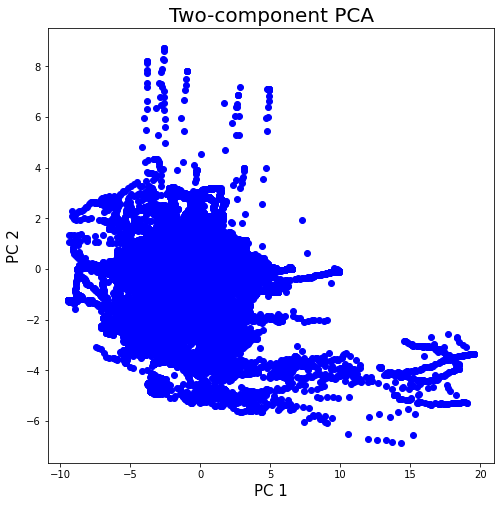

In [147]:
# Représentation dans le plan principal
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Two-component PCA', fontsize = 20)
plt.scatter(principalDf["principal component 1"], principalDf["principal component 2"], color='b')

[array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([ 1,  1, -1, ...,  1,  1,  1])]

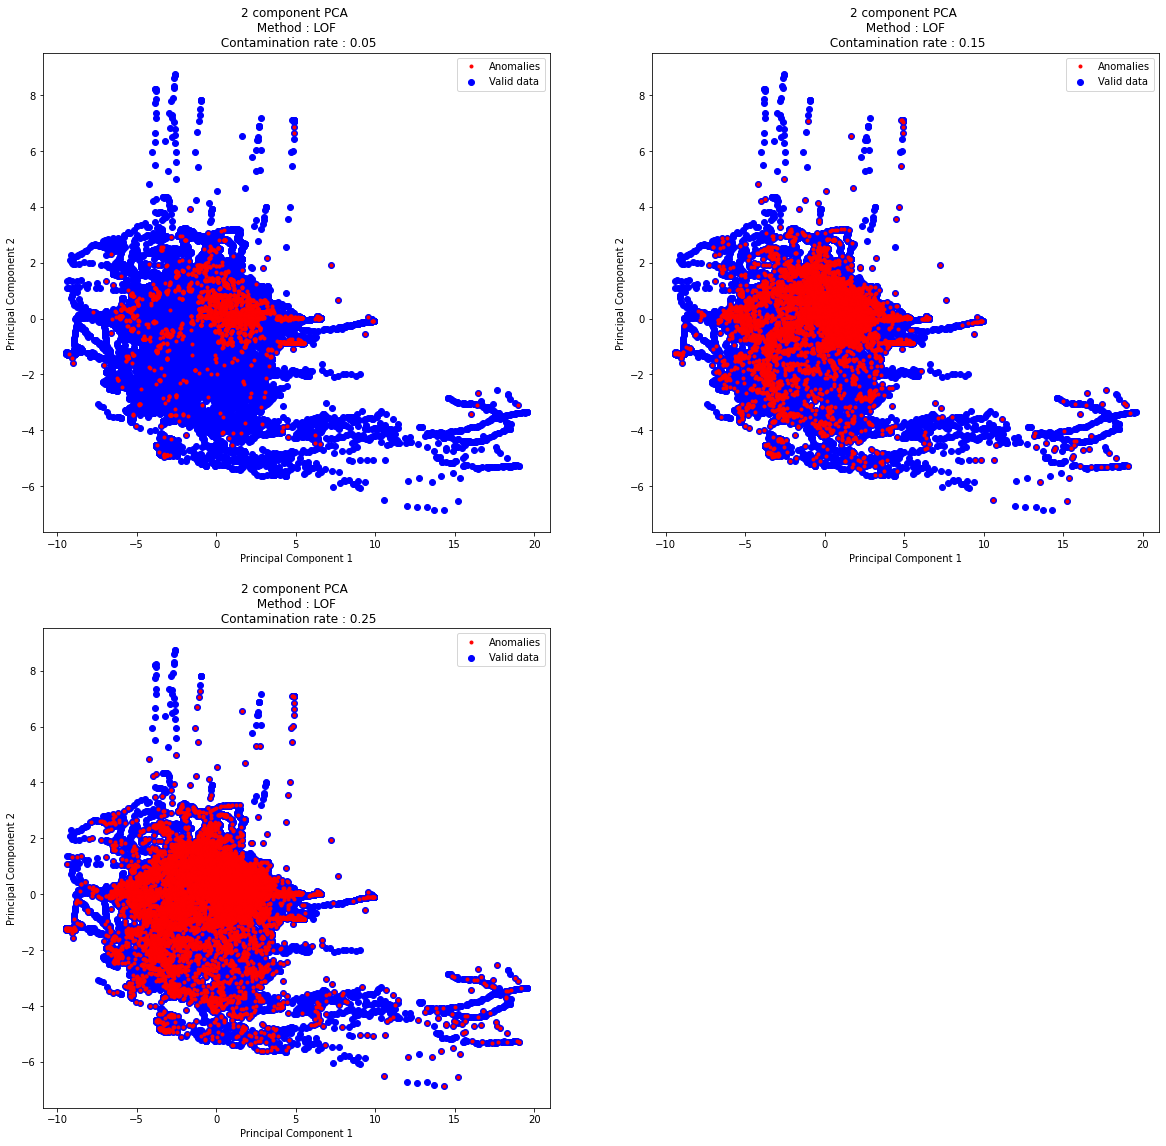

In [148]:
# Taux de contamination
contaminations = np.linspace(0.05,0.25,3)
clf_name = "LOF"

runAnomalies(principalDf, clf_name, contaminations)

On effectue les quatre méthodes de détection, toujours avec un contamination rate de 0,1.

In [149]:
methods = ["Elliptic", "LOF", "SVM", "Forest"]
predictions = []
for clf_name in methods:
    print("Method : {}".format(clf_name))
    predictions.append(runAnomalies(principalDf, clf_name, [0.1], False))

Method : Elliptic
Method : LOF
Method : SVM
Method : Forest


/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


On calcule le score d'anomalie pour chaque donnée. On rajoute au tableau une colonne 'Score' au dataframe

In [150]:
# Calcul des scores pour toutes les données
data_scores = [score(predictions, i) for i in range(n_data)]
data["Score"] = data_scores

data.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Score
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737,0
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472,0
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472,0
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472,0
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237,1


#### Première analyse:

On regarde le score moyen des données au sein de chaque fenêtre. Une fenêtre sera anormale si son score moyen est supérieur à 1.

In [155]:
df_windows = data.groupby(['day_cycle_window']).mean()

anomaly_windows = df_windows[df_windows["Score"] > 1]

print("Pourcentage de fenêtres anormales : {}%".format(round(len(anomaly_windows)/n_window*100,2)))

df_windows.head()

Pourcentage de fenêtres anormales : 12.52%


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Score
day_cycle_window,,,,,,,,,,,,
1_1_1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060,2.63
1_1_10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565,0.09
1_1_11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938,0.05
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699,0.03
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059,0.29


#### Deuxième analyse:

On regarde le pourcentage de données anormales au sein de chaque fenêtre. Comme dans la première partie, nous considérerons qu'une donnée est anormale si elle a été détectée par au moins deux méthodes.
Enfin, une fenêtre sera considérée comme anormale si elle contient plus de 50% d'anomalies.

On ajoute une colonne 'Anomaly' qui vaut 1 si la donnée est une anomalie, 0 sinon.

In [164]:
# Ajout de la colonne 'Anomalies'
data["Anomaly"] = [data["Score"][i] > 1 for i in range(n_data)]

data = data.drop(columns=["Score"])
data.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Anomaly
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737,False
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472,False
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472,False
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472,False
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237,False


In [166]:
# Calcul du nombre d'anomalies au sein de chaque fenêtre
df_windows = data.groupby(['day_cycle_window']).mean()

anomaly_windows = df_windows[df_windows["Anomaly"] > 0.5]

print("Pourcentage de fenêtres anormales : {}%".format(round(len(anomaly_windows)/n_window*100,2)))

df_windows.head()

Pourcentage de fenêtres anormales : 9.47%


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,Anomaly
day_cycle_window,,,,,,,,,,,,
1_1_1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060,0.93
1_1_10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565,0.00
1_1_11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938,0.00
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699,0.00
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059,0.00
